# Advanced Tutorial

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`
Precompiling project...
  ✓ ArrayInterface
  ✓ SentinelArrays
  ✓ CloseOpenIntervals
  ✓ ArrayInterfaceOffsetArrays
  ✓ TableOperations
  ✓ ArrayInterfaceStaticArrays
  ✓ LayoutPointers
  ✓ VectorizationBase
  ✓ SLEEFPirates
  ✓ SIMDDualNumbers
  ✓ LoopVectorization
  ✓ StatsPlots
  ✓ ReactiveMP
  ✓ RxInfer
  14 dependencies successfully precompiled in 93 seconds. 225 already precompiled.


In [66]:
using RxInfer, Plots

This notebook covers the fundamentals and advanced usage of the `RxInfer.jl` package.

This tutorial is also available in the [documentation](https://biaslab.github.io/RxInfer.jl/stable/).

## General model specification syntax

We use the `@model` macro from the `RxInfer.jl` package to create a probabilistic model $p(s, y)$ and we also specify extra constraints on the variational family of distributions $\mathcal{Q}$, used for approximating intractable posterior distributions.
Below there is a simple example of the general syntax for model specification. In this tutorial we do not cover all possible ways to create models or advanced features of `RxInfer.jl`.  Instead we refer the interested reader to the documentation for a more rigorous explanation and illustrative examples.

In [6]:
# the `@model` macro accepts a regular Julia function
@model function test_model1(s_mean, s_precision)
    
    # We use the `randomvar` function to create 
    # a random variable in our model
    s = randomvar()
    
    # the `tilde` operator creates a functional dependency
    # between variables in our model and can be read as 
    # `sampled from` or `is modeled by`
    s ~ Normal(mean = s_mean, precision = s_precision)
    
    # We use the `datavar` function to create 
    # observed data variables in our models
    # We also need to specify the type of our data 
    # In this example it is `Float64`
    y = datavar(Float64)
    
    y ~ Normal(mean = s, precision = 1.0)
    
    # It is possible to return something from the model specification (including variables and nodes)
    return "Hello world"
end

The `@model` macro creates a function with the same name and with the same set of input arguments as the original function (`test_model1(s_mean, s_precision)` in this example). The return value is modified in such a way to contain a reference to the model object as the first value and to the user specified variables in the form of a tuple as the second value.

In [8]:
modelgenerator = test_model1(0.0, 1.0)

model, returnval = RxInfer.create_model(modelgenerator)

(FactorGraphModel(), "Hello world")

The benefits of using model generator as a way to create a model is that it allows to change inference constraints and meta specification for nodes. We will talk about factorisation and form constraints and meta specification later on in this demo.

`RxInfer.jl` returns a factor graph-based representation of a model. We can examine this factor graph structure with the help of some utility functions such as: 
- `getnodes()`: returns an array of factor nodes in a corresponding factor graph
- `getrandom()`: returns an array of random variables in the model
- `getdata()`: returns an array of data inputs in the model
- `getconstant()`: returns an array of constant values in the model

In [9]:
getnodes(model)

FactorNodesCollection(nodes: 2)

In [10]:
getrandom(model) .|> name

1-element Vector{Symbol}:
 :s

In [11]:
getdata(model) .|> name

1-element Vector{Symbol}:
 :y

In [12]:
getconstant(model) .|> getconst

3-element Vector{Float64}:
 0.0
 1.0
 1.0

It is also possible to use control flow statements such as `if` or `for` blocks in the model specification function. In general, any valid snippet of Julia code can be used inside the `@model` block. As an example consider the following (valid!) model:

In [13]:
@model function test_model2(n)
    
    if n <= 1
        error("`n` argument must be greater than one.")
    end
    
    # `randomvar(n)` creates a dense sequence of 
    # random variables
    s = randomvar(n)
    
    # `datavar(Float64, n)` creates a dense sequence of 
    # observed data variables of type `Float64`
    y = datavar(Float64, n)
    
    s[1] ~ Normal(mean = 0.0, precision = 0.1)
    y[1] ~ Normal(mean = s[1], precision = 1.0)
    
    for i in 2:n
        s[i] ~ Normal(mean = s[i - 1], precision = 1.0)
        y[i] ~ Normal(mean = s[i], precision = 1.0)
    end
    
end

In [15]:
model, _ = RxInfer.create_model(test_model2(10));

In [16]:
# An amount of factor nodes in generated Factor Graph
getnodes(model) |> length

20

In [17]:
# An amount of random variables
getrandom(model) |> length

10

In [18]:
# An amount of data inputs
getdata(model) |> length

10

In [19]:
# An amount of constant values
getconstant(model) |> length

21

It is also possible to use complex expressions inside the functional dependency expressions

```julia
y ~ NormalMeanPrecision(2.0 * (s + 1.0), 1.0)
```

The `~` operator automatically creates a random variable if none was created before with the same name and throws an error if this name already exists

```julia
# s = randomvar() here is optional
# `~` creates random variables automatically
s ~ NormalMeanPrecision(0.0, 1.0)
```

An example model which will throw an error:

```julia
@model function error_model1()
    s = 1.0
    s ~ NormalMeanPrecision(0.0, 1.0)
end
```

By default the `RxInfer.jl` package creates new references for constants (literals like `0.0` or `1.0`) in a model. In some situations this may not be efficient, especially when these constants represent large matrices. `RxInfer.jl` will by default create new copies of some constant (e.g. matrix) in a model every time it uses it. However it is possible to use `constvar()` function to create and reuse similar constants in the model specification syntax as

```julia
# Creates constant reference in a model with a prespecified value
c = constvar(0.0)
```

An example:

In [21]:
@model function test_model5(dim::Int, n::Int, A::Matrix, P::Matrix, Q::Matrix)
    
    s = randomvar(n)
    
    y = datavar(Vector{Float64}, n)
    
    # Here we create constant references
    # for constant matrices in our model 
    # to make inference more memory efficient
    cA = constvar(A)
    cP = constvar(P)
    cQ = constvar(Q)
    
    s[1] ~ MvNormal(mean = zeros(dim), covariance = cP)
    y[1] ~ MvNormal(mean = s[1], covariance = cQ)
    
    for i in 2:n
        s[i] ~ MvNormal(mean = cA * s[i - 1], covariance = cP)
        y[i] ~ MvNormal(mean = s[i], covariance = cQ)
    end
    
end

The `~` expression can also return a reference to a newly created node in a corresponding factor graph for convenience in later usage:

```julia
@model function test_model()

    # In this example `ynode` refers to the corresponding 
    # `GaussianMeanVariance` node created in the factor graph
    ynode, y ~ GaussianMeanVariance(0.0, 1.0)
    
    return ynode, y
end
```

## Probabilistic inference in RxInfer.jl

`RxInfer.jl` uses the `Rocket.jl` package API for inference routines. `Rocket.jl` is a reactive programming extension for Julia that is higly inspired by `RxJS` and similar libraries from the `Rx` ecosystem. It consists of **observables**, **actors**, **subscriptions** and **operators**. For more information and rigorous examples see [Rocket.jl github page](https://github.com/biaslab/Rocket.jl).

### Observables
Observables are lazy push-based collections and they deliver their values over time.

In [34]:
# Timer that emits a new value every second and has an initial one second delay 
observable = timer(300, 300)

TimerObservable(300, 300)

A subscription allows us to subscribe on future values of some observable, and actors specify what to do with these new values:

In [35]:
actor = (value) -> println(value)
subscription1 = subscribe!(observable, actor)

TimerSubscription()

0
1
2
3
4
5
6


In [36]:
# We always need to unsubscribe from some observables
unsubscribe!(subscription1)

In [37]:
# We can modify our observables
modified = observable |> filter(d -> rem(d, 2) === 1) |> map(Int, d -> d ^ 2)

ProxyObservable(Int64, MapProxy(Int64))

In [38]:
subscription2 = subscribe!(modified, (value) -> println(value))

TimerSubscription()

1
9
25
49


In [39]:
unsubscribe!(subscription2)

81


In [40]:
@model function coin_toss_model(n)

    # `datavar` creates data 'inputs' in our model
    # We will pass data later on to these inputs
    # In this example we create a sequence of inputs that accepts Float64
    y = datavar(Float64, n)
    
    # We endow θ parameter of our model with some prior
    θ ~ Beta(2.0, 7.0)
    
    # We assume that the outcome of each coin flip 
    # is modeled by a Bernoulli distribution
    for i in 1:n
        y[i] ~ Bernoulli(θ)
    end
    
    # We return references to our data inputs and θ parameter
    # We will use these references later on during the inference step
    return y, θ
end

We can call the `inference` function to run inference in such model:


In [43]:
p = 0.75 # Bias of a coin

dataset = float.(rand(Bernoulli(p), 500));

result = inference(
    model = coin_toss_model(length(dataset)),
    data  = (y = dataset, )
)

println("Inferred bias: ", mean_var(result.posteriors[:θ]))

Inferred bias: (0.7269155206286837, 0.00038923401274081065)


We can see that the inferred bias is quite close to the actual value we used in the dataset generation.

The `RxInfer.jl` package's API is more flexible (and reactive!) and can return posterior marginal distributions in our specified model in the form of an observable. It is possible to subscribe on its future updates, but for convenience `RxInfer.jl` only caches the last obtained values of all marginals in a model. To get a reference for the posterior marginal of some random variable in a model `RxInfer.jl` exports two functions: 

- `getmarginal(x)`: for a single random variable `x`
- `getmarginals(xs)`: for a dense sequence of random variables `sx`

Let's see how it works in practice. Here we create a simple coin toss model. We assume that observations are governed by the `Bernoulli` distribution with unknown bias parameter `θ`. To have a fully Bayesian treatment of this problem we endow `θ` with the `Beta` prior.

In [44]:
_, (y, θ) = RxInfer.create_model(coin_toss_model(length(dataset)));

In [45]:
# As soon as we have a new value for the marginal posterior over the `θ` variable
# we simply print the first two statistics of it
θ_subscription = subscribe!(getmarginal(θ), (marginal) -> println("New update: mean(θ) = ", mean(marginal), ", std(θ) = ", std(marginal)));

To pass data to our model we use `update!` function

In [46]:
update!(y, dataset)

New update: mean(θ) = 0.7269155206286837, std(θ) = 0.01972901448985252


In [47]:
# It is necessary to always unsubscribe from running observables
unsubscribe!(θ_subscription)

In [48]:
# The ReactiveMP.jl inference backend is lazy and does not compute posterior marginals if no-one is listening for them
# At this moment we have already unsubscribed from the new posterior updates so this `update!` does nothing
update!(y, dataset)

`Rocket.jl` provides some useful built-in actors for obtaining posterior marginals especially with static datasets.

In [49]:
# the `keep` actor simply keeps all incoming updates in an internal storage, ordered
θvalues = keep(Marginal)

KeepActor{Marginal}(Marginal[])

In [50]:
# `getmarginal` always emits last cached value as its first value
subscribe!(getmarginal(θ) |> take(1), θvalues);

In [51]:
getvalues(θvalues)

1-element Vector{Marginal}:
 Marginal(Beta{Float64}(α=370.0, β=139.0))

In [52]:
subscribe!(getmarginal(θ) |> take(1), θvalues);

In [53]:
getvalues(θvalues)

2-element Vector{Marginal}:
 Marginal(Beta{Float64}(α=370.0, β=139.0))
 Marginal(Beta{Float64}(α=370.0, β=139.0))

In [54]:
# the `buffer` actor keeps very last incoming update in an internal storage and can also store 
# an array of updates for a sequence of random variables
θbuffer = buffer(Marginal, 1)

BufferActor{Marginal, Vector{Marginal}}(Marginal[#undef])

In [55]:
subscribe!(getmarginals([ θ ]) |> take(1), θbuffer);

In [56]:
getvalues(θbuffer)

1-element Vector{Marginal}:
 Marginal(Beta{Float64}(α=370.0, β=139.0))

In [57]:
subscribe!(getmarginals([ θ ]) |> take(1), θbuffer);

In [58]:
getvalues(θbuffer)

1-element Vector{Marginal}:
 Marginal(Beta{Float64}(α=370.0, β=139.0))

## Reactive Online Inference

RxInfer.jl naturally supports reactive streams of data and it is possible to run reactive inference with some external datasource.

In [59]:
@model function online_coin_toss_model()
    
    # We create datavars for the prior 
    # over `θ` variable
    θ_a = datavar(Float64)
    θ_b = datavar(Float64)
    
    θ ~ Beta(θ_a, θ_b)
    
    y = datavar(Float64)
    y ~ Bernoulli(θ)

end

In [60]:
autoupdates = @autoupdates begin 
    θ_a, θ_b = params(q(θ))
end

(θ_a,θ_b = params(q(θ)),)

In [64]:
rxresult = rxinference(
    model = online_coin_toss_model(),
    data  = (y = dataset, ),
    autoupdates = autoupdates,
    historyvars = (θ = KeepLast(), ),
    keephistory = length(dataset),
    initmarginals = (
        θ = vague(Beta),
    ),
    autostart = true
);

┌ Info: Saved animation to 
│   fn = /Users/bvdmitri/.julia/dev/RxInfer/examples/tmp.gif
└ @ Plots /Users/bvdmitri/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/Users/bvdmitri/.julia/dev/RxInfer/examples/tmp.gif")
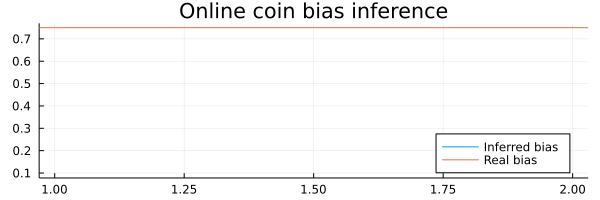

In [78]:
animation = @animate for i in 1:length(dataset)
    plot(mean.(rxresult.history[:θ][1:i]), ribbon = std.(rxresult.history[:θ][1:i]), title = "Online coin bias inference", label = "Inferred bias", legend = :bottomright)
    hline!([ p ], label = "Real bias", size = (600, 200))
end

gif(animation, fps = 30)

In this example we used static dataset and the `history` field of the reactive inference result, but the `rxinference` function also supports any real-time reactive stream and can run indefinitely.

That was an example of exact Bayesian inference with Sum-Product (or Belief Propagation) algorithm. However, `ReactiveMP.jl` is not limited to only the sum-product algorithm but it also supports variational message passing with [Constrained Bethe Free Energy Minimisation](https://www.mdpi.com/1099-4300/23/7/807).

## Variational inference

On a very high-level, ReactiveMP.jl is aimed to solve the Constrained Bethe Free Energy minimisation problem. For this task we approximate our exact posterior marginal distribution by some family of distributions $q \in \mathcal{Q}$. Often this involves assuming some factorization over $q$. For this purpose the `@model` macro supports optional `where { ... }` clauses for every `~` expression in a model specification.

In [79]:
@model function test_model6_with_manual_constraints(n)
    τ ~ Gamma(shape = 1.0, rate = 1.0) 
    μ ~ Normal(mean = 0.0, variance = 100.0)
    
    y = datavar(Float64, n)
    
    for i in 1:n
        # Here we assume a mean-field assumption on our 
        # variational family of distributions locally for the current node
        y[i] ~ Normal(mean = μ, precision = τ) where { q = q(y[i])q(μ)q(τ) }
    end

end

In this example we specified an extra constraints for $q_a$ for Bethe factorisation:

$$
q(s) = \prod_{a \in \mathcal{V}} q_a(s_a) \prod_{i \in \mathcal{E}} q_i^{-1}(s_i)
$$

There are several options to specify the mean-field factorisation constraint. 

```julia
y[i] ~ NormalMeanPrecision(μ, τ) where { q = q(y[i])q(μ)q(τ) } # With names from model specification
y[i] ~ NormalMeanPrecision(μ, τ) where { q = q(out)q(mean)q(precision) } # With names from node specification
y[i] ~ NormalMeanPrecision(μ, τ) where { q = MeanField() } # With alias name
```

It is also possible to use local structured factorisation:

```julia
y[i] ~ NormalMeanPrecision(μ, τ) where { q = q(y[i], μ)q(τ) } # With names from model specification
y[i] ~ NormalMeanPrecision(μ, τ) where { q = q(out, mean)q(precision) } # With names from node specification
```

### RxInfer.jl constraints macro

`RxInfer.jl` package exports `@constraints` macro to simplify factorisation and form constraints specification. Read more about `@constraints` macro in the corresponding documentation section, here we show a simple example of the same factorisation constraints specification, but with `@constraints` macro:

In [80]:
constraints6 = @constraints begin
     q(μ, τ) = q(μ)q(τ) # Mean-Field over `μ` and `τ`
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(μ, τ) = q(μ)q(τ)
Options:
  warn = true


**Note**: `where` blocks have higher priority over constraints specification

In [90]:
@model function test_model6(n)
    τ ~ Gamma(shape = 1.0, rate = 1.0) 
    μ ~ Normal(mean = 0.0, variance = 100.0)
    
    y = datavar(Float64, n)
    
    for i in 1:n
        # Here we assume a mean-field assumption on our 
        # variational family of distributions locally for the current node
        y[i] ~ Normal(mean = μ, precision = τ)
    end
    
    return μ, τ, y
end

### Inference

To run inference in this model we again need to create a synthetic dataset:

In [91]:
dataset = rand(Normal(-3.0, inv(sqrt(5.0))), 1000);

#### `inference` function

In order to simplify model and inference testing, `RxInfer.jl` exports pre-written inference function, that is aimed for simple use cases with static datasets:

In [92]:
?inference

search: inference InferenceResult rxinference RxInferenceEngine



```
inference(
    model::ModelGenerator; 
    data,
    initmarginals           = nothing,
    initmessages            = nothing,
    constraints             = nothing,
    meta                    = nothing,
    options                 = nothing,
    returnvars              = nothing, 
    iterations              = nothing,
    free_energy             = false,
    free_energy_diagnostics = BetheFreeEnergyDefaultChecks,
    showprogress            = false,
    callbacks               = nothing,
)
```

This function provides a generic (but somewhat limited) way to perform probabilistic inference in ReactiveMP.jl. Returns `InferenceResult`.

## Arguments

For more information about some of the arguments, please check below.

  * `model::ModelGenerator`: specifies a model generator, with the help of the `Model` function
  * `data`: `NamedTuple` or `Dict` with data, required
  * `initmarginals = nothing`: `NamedTuple` or `Dict` with initial marginals, optional, defaults to nothing
  * `initmessages = nothing`: `NamedTuple` or `Dict` with initial messages, optional, defaults to nothing
  * `constraints = nothing`: constraints specification object, optional, see `@constraints`
  * `meta  = nothing`: meta specification object, optional, may be required for some models, see `@meta`
  * `options = nothing`: model creation options, optional
  * `returnvars = nothing`: return structure info, optional, defaults to return everything at each iteration, see below for more information
  * `iterations = nothing`: number of iterations, optional, defaults to `nothing`, we do not distinguish between variational message passing or Loopy belief propagation or expectation propagation iterations, see below for more information
  * `free_energy = false`: compute the Bethe free energy, optional, defaults to false. Can be passed a floating point type, e.g. `Float64`, for better efficiency, but disables automatic differentiation packages, such as ForwardDiff.jl
  * `free_energy_diagnostics = BetheFreeEnergyDefaultChecks`: free energy diagnostic checks, optional, by default checks for possible `NaN`s and `Inf`s. `nothing` disables all checks.
  * `showprogress = false`: show progress module, optional, defaults to false
  * `callbacks = nothing`: inference cycle callbacks, optional, see below for more info
  * `warn = true`: enables/disables warnings

## Note on NamedTuples

When passing `NamedTuple` as a value for some argument, make sure you use a trailing comma for `NamedTuple`s with a single entry. The reason is that Julia treats `returnvars = (x = KeepLast())` and  `returnvars = (x = KeepLast(), )` expressions differently. First expression creates (or **overwrites!**) new local/global variable named `x` with contents `KeepLast()`. The second expression (note traling comma) creates `NamedTuple` with `x` as a key and `KeepLast()` as a value assigned for this key.

## Extended information about some of the arguments

  * ### `model`

The `model` argument accepts a `ModelGenerator` as its input. The easiest way to create the `ModelGenerator` is to use the `Model` function. The `Model` function accepts a model name as its first argument and the rest is passed directly to the model constructor. For example:

```julia
result = inference(
    # Creates `coin_toss(some_argument, some_keyword_argument = 3)`
    model = Model(coin_toss, some_argument; some_keyword_argument = 3)
)
```

**Note**: The `model` keyword argument does not accept a `FactorGraphModel` instance as a value, as it needs to inject `constraints` and `meta` during the inference procedure.

  * ### `initmarginals`

In general for variational message passing every marginal distribution in a model needs to be pre-initialised. In practice, however, for many models it is sufficient enough to initialise only a small subset of variables in the model.

  * ### `initmessages`

Loopy belief propagation may need some messages in a model to be pre-initialised.

  * ### `options`
  * `limit_stack_depth`: limits the stack depth for computing messages, helps with `StackOverflowError` for some huge models, but reduces the performance of inference backend. Accepts integer as an argument that specifies the maximum number of recursive depth. Lower is better for stack overflow error, but worse for performance.
  * `pipeline`: changes the default pipeline for each factor node in the graph
  * `global_reactive_scheduler`: changes the scheduler of reactive streams, see Rocket.jl for more info, defaults to no scheduler
  * ### `returnvars`

`returnvars` specifies the variables of interests and the amount of information to return about their posterior updates. 

`returnvars` accepts a `NamedTuple` or `Dict` or return var specification. There are two specifications:

  * `KeepLast`: saves the last update for a variable, ignoring any intermediate results during iterations
  * `KeepEach`: saves all updates for a variable for all iterations

Note: if `iterations` are specified as a number, the `inference` function tracks and returns every update for each iteration for every random variable in the model (equivalent to `KeepEach()`). If number of iterations is set to `nothing`, the `inference` function saves the 'last' (and the only one) update for every random variable in the model (equivalent to `KeepLast()`).  Use `iterations = 1` to force `KeepEach()` setting when number of iterations is equal to `1` or set `returnvars = KeepEach()` manually.

Example: 

```julia
result = inference(
    ...,
    returnvars = (
        x = KeepLast(),
        τ = KeepEach()
    )
)
```

It is also possible to set iether `returnvars = KeepLast()` or `returnvars = KeepEach()` that acts as an alias and sets the given option for **all** random variables in the model.

# Example:

```julia
result = inference(
    ...,
    returnvars = KeepLast()
)
```

  * ### `iterations`

Specifies the number of variational (or loopy BP) iterations. By default set to `nothing`, which is equivalent of doing 1 iteration. 

  * ### `free_energy`

This setting specifies whenever the `inference` function should return Bethe Free Energy (BFE) values.  Note, however, that it may be not possible to compute BFE values for every model. 

Additionally, the argument may accept a floating point type, instead of a `Bool` value. Using his option, e.g.`Float64`, improves performance of Bethe Free Energy computation, but restricts using automatic differentiation packages.

  * ### `free_energy_diagnostics`

This settings specifies either a single or a tuple of diagnostic checks for Bethe Free Energy values stream. By default checks for `NaN`s and `Inf`s. See also [`BetheFreeEnergyCheckNaNs`](@ref) and [`BetheFreeEnergyCheckInfs`](@ref). Pass `nothing` to disable any checks.

  * ### `callbacks`

The inference function has its own lifecycle. The user is free to provide some (or none) of the callbacks to inject some extra logging or other procedures in the inference function, e.g.

```julia
result = inference(
    ...,
    callbacks = (
        on_marginal_update = (model, name, update) -> println("$(name) has been updated: $(update)"),
        after_inference    = (args...) -> println("Inference has been completed")
    )
)
```

The list of all possible callbacks is present below:

  * `:on_marginal_update`:    args: (model::FactorGraphModel, name::Symbol, update)
  * `:before_model_creation`: args: ()
  * `:after_model_creation`:  args: (model::FactorGraphModel, returnval)
  * `:before_inference`:      args: (model::FactorGraphModel)
  * `:before_iteration`:      args: (model::FactorGraphModel, iteration::Int)
  * `:before_data_update`:    args: (model::FactorGraphModel, data)
  * `:after_data_update`:     args: (model::FactorGraphModel, data)
  * `:after_iteration`:       args: (model::FactorGraphModel, iteration::Int)
  * `:after_inference`:       args: (model::FactorGraphModel)

See also: [`InferenceResult`](@ref)


In [93]:
result = inference(
    model         = test_model6(length(dataset)),
    data          = (y = dataset, ),
    constraints   = constraints6, 
    initmarginals = (μ = vague(NormalMeanPrecision), τ = vague(GammaShapeRate)),
    returnvars    = (μ = KeepLast(), τ = KeepLast()),
    iterations    = 10,
    free_energy   = true,
    showprogress  = true
)

Inference results:
-----------------------------------------
Free Energy: Real[14763.3, 3275.89, 675.461, 636.339, 636.339, 636.339, 636.339, 636.339, 636.339, 636.339]
-----------------------------------------
μ = NormalWeightedMeanPrecision{Float64}(xi=-14582.748329349852, w=4857.881779409289...
τ = GammaShapeRate{Float64}(a=501.0, b=103.13158163695265)


In [94]:
println("μ: mean = ", mean(result.posteriors[:μ]), ", std = ", std(result.posteriors[:μ]))

μ: mean = -3.0018738601586743, std = 0.014347509770194788


In [95]:
println("τ: mean = ", mean(result.posteriors[:τ]), ", std = ", std(result.posteriors[:τ]))

τ: mean = 4.857871779409313, std = 0.21703370519801493


#### Manual inference

For advanced use cases it is advised to write inference functions manually as it provides more flexibility, here is an example of manual inference specification:

In [96]:
model, (μ, τ, y) = RxInfer.create_model(test_model6(length(dataset)), constraints6);

For variational inference we also usually need to set initial marginals for our inference procedure. For that purpose `ReactiveMP.jl` export the `setmarginal!` function:

In [97]:
setmarginal!(μ, vague(NormalMeanPrecision))
setmarginal!(τ, vague(GammaShapeRate))

In [98]:
μ_values = keep(Marginal)
τ_values = keep(Marginal)

μ_subscription = subscribe!(getmarginal(μ), μ_values)
τ_subscription = subscribe!(getmarginal(τ), τ_values)

for i in 1:10
    update!(y, dataset)
end

In [99]:
getvalues(μ_values)

10-element Vector{Marginal}:
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-3.0078837996112455e-9, w=0.010000001002000566))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-27.540352983059204, w=9.184368269258622))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-9550.394431521216, w=3181.4810466983317))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14575.083700188936, w=4855.328503109102))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14582.74067602948, w=4857.879229900266))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14582.748321711857, w=4857.88177686499))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14582.748329342252, w=4857.8817794067945))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14582.748329349852, w=4857.881779409289))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14582.748329349843, w=4857.881779409289))
 Marginal(NormalWeightedMeanPrecision{Float64}(xi=-14582.748329349852, w=4857.881779409289))

In [100]:
getvalues(τ_values)

10-element Vector{Marginal}:
 Marginal(GammaShapeRate{Float64}(a=501.0, b=5.000000000046079e14))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=54608.66462912059))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=157.47432324425253))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.18581565332515))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.13163576251473))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.13158169096987))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.13158163700653))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.13158163695265))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.13158163695267))
 Marginal(GammaShapeRate{Float64}(a=501.0, b=103.13158163695265))

In [101]:
println("μ: mean = ", mean(last(μ_values)), ", std = ", std(last(μ_values)))

μ: mean = -3.0018738601586743, std = 0.014347509770194788


In [102]:
println("τ: mean = ", mean(last(τ_values)), ", std = ", std(last(τ_values)))

τ: mean = 4.857871779409313, std = 0.21703370519801493


### Form constraints

In order to support form constraints, the `randomvar()` function also supports a `where { ... }` clause with some optional arguments. One of these arguments is `form_constraint` that allows us to specify a form constraint to the random variables in our model. Another one is `prod_constraint` that allows to specify an additional constraints during computation of product of two colliding messages. For example we can perform the EM algorithm if we assign a point mass contraint on some variables in our model.

<img style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;" src="./pics/posterior.png" />

In [103]:
@model function test_model7_with_manual_constraints(n)
    τ ~ Gamma(shape = 1.0, rate = 1.0) 
    
    # In case of form constraints `randomvar()` call is necessary
    μ = randomvar() where { marginal_form_constraint = PointMassFormConstraint() }
    μ ~ Normal(mean = 0.0, variance = 100.0)
    
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ Normal(mean = μ, precision = τ) where { q = q(y[i])q(μ)q(τ) }
    end
    
    return μ, τ, y
end

As in the previous example we can use `@constraints` macro to achieve the same goal with a nicer syntax:

In [104]:
constraints7 = @constraints begin 
    q(μ) :: PointMass
    
    q(μ, τ) = q(μ)q(τ) # Mean-Field over `μ` and `τ`
end

Constraints:
  marginals form:
    q(μ) :: PointMassFormConstraint() [ prod_constraint = ProdGeneric(fallback = ProdAnalytical()) ]
  messages form:
  factorisation:
    q(μ, τ) = q(μ)q(τ)
Options:
  warn = true


In this example we specified an extra constraints for $q_i$ for Bethe factorisation:

$$
q(s) = \prod_{a \in \mathcal{V}} q_a(s_a) \prod_{i \in \mathcal{E}} q_i^{-1}(s_i)
$$

In [105]:
@model function test_model7(n)
    τ ~ Gamma(shape = 1.0, rate = 1.0) 
    
    # In case of form constraints `randomvar()` call is necessary
    μ = randomvar()
    μ ~ Normal(mean = 0.0, variance = 100.0)
    
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ Normal(mean = μ, precision = τ)
    end
    
    return μ, τ, y
end

In [108]:
model, (μ, τ, y) = RxInfer.create_model(test_model7(length(dataset)), constraints7);

In [109]:
setmarginal!(μ, vague(NormalMeanPrecision))
setmarginal!(τ, PointMass(1.0))

μ_values = keep(Marginal)
τ_values = keep(Marginal)

μ_subscription = subscribe!(getmarginal(μ), μ_values)
τ_subscription = subscribe!(getmarginal(τ), τ_values)

for i in 1:10
    update!(y, dataset)
end

In [110]:
getvalues(μ_values) |> last

Marginal(PointMass{Float64}(-3.0018738663257363))

In [111]:
getvalues(τ_values) |> last 

Marginal(GammaShapeRate{Float64}(a=501.0, b=103.02865611861155))

By default `ReactiveMP.jl` tries to compute an analytical product of two colliding messages and throws an error if no analytical solution is known. However, it is possible to fall back to a generic product that does not require an analytical solution to be known. In this case the inference backend will simply propagate the product of two messages in a form of a tuple. It is not possible to use such a tuple-product during an inference and in this case it is mandatory to use some form constraint to approximate this product.

```julia
μ = randomvar() where { 
    prod_constraint = ProdGeneric(),
    form_constraint = SampleListFormConstraint() 
}
```

Sometimes it is useful to preserve a specific parametrisation of the resulting product later on in an inference procedure. `ReactiveMP.jl` exports a special `prod_constraint` called `ProdPreserveType` especially for that purpose:

```julia
μ = randomvar() where { prod_constraint = ProdPreserveType(NormalWeightedMeanPrecision) }
```

**Note**: `@constraints` macro specifies required `prod_constraint` automatically.

### Free Energy

During variational inference `ReactiveMP.jl` optimises a special functional called the Bethe Free Energy functional. It is possible to obtain its values for all VMP iterations with the `score` function.

In [112]:
model, (μ, τ, y) = RxInfer.create_model(test_model6(length(dataset)), constraints6);

In [115]:
bfe_observable = score(model, Float64, BetheFreeEnergy())

ProxyObservable(Float64, MapProxy(Tuple{ReactiveMP.InfCountingReal{Float64}, ReactiveMP.InfCountingReal{Float64}}))

In [116]:
bfe_subscription = subscribe!(bfe_observable, (fe) -> println("Current BFE value: ", fe));

In [117]:
# Reset the model with vague marginals
setmarginal!(μ, vague(NormalMeanPrecision))
setmarginal!(τ, vague(GammaShapeRate))

for i in 1:10
    update!(y, dataset)
end

Current BFE value: 648.8636936648963
Current BFE value: 636.3387341768112
Current BFE value: 636.3387339278929
Current BFE value: 636.3387339278929
Current BFE value: 636.338733927892
Current BFE value: 636.338733927892
Current BFE value: 636.3387339278929
Current BFE value: 636.338733927892
Current BFE value: 636.3387339278929
Current BFE value: 636.338733927892


In [118]:
# It always necessary to unsubscribe and release computer resources
unsubscribe!([ μ_subscription, τ_subscription, bfe_subscription ])

### Meta data specification

During model specification some functional dependencies may accept an optional `meta` object in the `where { ... }` clause. The purpose of the `meta` object is to adjust, modify or supply some extra information to the inference backend during the computations of the messages. The `meta` object for example may contain an approximation method that needs to be used during various approximations or it may specify the tradeoff between accuracy and performance:

```julia
# In this example the `meta` object for the autoregressive `AR` node specifies the variate type of 
# the autoregressive process and its order. In addition it specifies that the message computation rules should
# respect accuracy over speed with the `ARsafe()` strategy. In contrast, `ARunsafe()` strategy tries to speedup computations
# by cost of possible numerical instabilities during an inference procedure
s[i] ~ AR(s[i - 1], θ, γ) where { q = q(s[i - 1], s[i])q(θ)q(γ), meta = ARMeta(Multivariate, order, ARsafe()) }
...
s[i] ~ AR(s[i - 1], θ, γ) where { q = q(s[i - 1], s[i])q(θ)q(γ), meta = ARMeta(Univariate, order, ARunsafe()) }
```

Another example with `GaussianControlledVariance`, or simply `GCV` [see Hierarchical Gaussian Filter], node:

```julia
# In this example we specify structured factorisation and flag meta with `GaussHermiteCubature` 
# method with `21` sigma points for approximation of non-lineariety between hierarchy layers
xt ~ GCV(xt_min, zt, real_k, real_w) where { q = q(xt, xt_min)q(zt)q(κ)q(ω), meta = GCVMetadata(GaussHermiteCubature(21)) }
```

The Meta object is useful to pass any extra information to a node that is not a random variable or constant model variable. It may include extra approximation methods, differentiation methods, optional non-linear functions, extra inference parameters etc.

### RxInfer.jl `@meta` macro

Users can use `@meta` macro from the `RxInfer.jl` package to achieve the same goal. Read more about `@meta` macro in the corresponding documentation section. Here is a simple example of the same meta specification:

In [119]:
@meta begin 
     AR(s, θ, γ) -> ARMeta(Multivariate, 5, ARsafe())
end

Meta specification:
  AR(s, θ, γ) -> ARMeta{Multivariate, ARsafe}(5, ARsafe())
Options:
  warn = true

## Creating custom nodes and message computation rules

### Custom nodes

To create a custom functional form and to make it available during model specification `ReactiveMP.jl` exports the `@node` macro:

```julia
# `@node` macro accepts a name of the functional form, its type, either `Stochastic` or `Deterministic` and an array of interfaces:
@node NormalMeanVariance Stochastic [ out, μ, v ]

# Interfaces may have aliases for their names that might be convenient for factorisation constraints specification
@node NormalMeanVariance Stochastic [ out, (μ, aliases = [ mean ]), (v, aliases = [ var ]) ]

# `NormalMeanVariance` structure declaration must exist, otherwise `@node` macro will throw an error
struct NormalMeanVariance end 

@node NormalMeanVariance Stochastic [ out, μ, v ]

# It is also possible to use function objects as a node functional form
function dot end

# Syntax for functions is a bit differet, as it is necesssary to use `typeof(...)` function for them 
# out = dot(x, a)
@node typeof(dot) Deterministic [ out, x, a ]
```

**Note**: Deterministic nodes do not support factorisation constraints with the `where { q = ... }` clause.

After that it is possible to use the newly created node during model specification:

```julia
@model function test_model()
    ...
    y ~ dot(x, a)
    ...
end
```

### Custom messages computation rules

`RxInfer.jl` exports the `@rule` macro to create custom message computation rules. For example let us create a simple `+` node to be available for usage in the model specification usage. We refer to *A Factor Graph Approach to Signal Modelling , System Identification and Filtering* [ Sascha Korl, 2005, page 32 ] for a rigorous explanation of the `+` node in factor graphs. According to Korl, assuming that inputs are Gaussian Sum-Product message computation rule for `+` node is the following:

$$\begin{aligned}
\mu_z = \mu_x + \mu_y\\
V_z = V_x + V_y
\end{aligned}$$

To specify this in `RxInfer.jl` we use the `@node` and `@rule` macros:
 
```julia
@node typeof(+) Deterministic  [ z, x, y ]

@rule typeof(+)(:z, Marginalisation) (m_x::UnivariateNormalDistributionsFamily, m_y::UnivariateNormalDistributionsFamily) = begin
    x_mean, x_var = mean_var(m_x)
    y_mean, y_var = mean_var(m_y)
    return NormalMeanVariance(x_mean + y_mean, x_var + y_var)
end
```

In this example, for the `@rule` macro, we specify a type of our functional form: `typeof(+)`. Next, we specify an edge we are going to compute an outbound message for. `Marginalisation` indicates that the corresponding message respects the marginalisation constraint for posterior over corresponding edge:

$$\begin{aligned}
q(z) = \int q(z, x, y) \mathrm{d}x\mathrm{d}y
\end{aligned}$$

If we look on difference between sum-product rules and variational rules with mean-field assumption we notice that they require different local information to compute an outgoing message:

<div style="width:100%">
<div style="width:50%; left:25%; position: relative; padding-top: 50px; padding-bottom: 50px">
<img style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;" src="./pics/sp.png" align="left"/>

<img style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;" src="./pics/vmp.png" align="left" />
</div>
<div style="width:50%">&nbsp;&nbsp;&nbsp;&nbsp;</div>
</div

<div style="width:100%">
$$\begin{aligned}
\mu(z) = \int f(x, y, z)\mu(x)\mu(y)\mathrm{d}x\mathrm{d}y
\end{aligned}$$

$$\begin{aligned}
\nu(z) = \exp{ \int \log f(x, y, z)q(x)q(y)\mathrm{d}x\mathrm{d}y }
\end{aligned}$$
</div>

The `@rule` macro supports both cases with special prefixes during rule specification:
- `m_` prefix corresponds to the incoming message on a specific edge
- `q_` prefix corresponds to the posterior marginal of a specific edge

Example of a Sum-Product rule with `m_` messages used:

```julia
@rule NormalMeanPrecision(:μ, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, m_τ::PointMass) = begin 
    m_out_mean, m_out_cov = mean_cov(m_out)
    return NormalMeanPrecision(m_out_mean, inv(m_out_cov + inv(mean(m_τ))))
end
```

Example of a Variational rule with Mean-Field assumption with `q_` posteriors used:

```julia
@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::Any, q_τ::Any) = begin 
    return NormalMeanPrecision(mean(q_out), mean(q_τ))
end
```

`RxInfer.jl` also supports structured rules. It is possible to obtain joint marginal over a set of edges:

```julia
@rule NormalMeanPrecision(:τ, Marginalisation) (q_out_μ::Any, ) = begin
    m, V = mean_cov(q_out_μ)
    θ = 2 / (V[1,1] - V[1,2] - V[2,1] + V[2,2] + abs2(m[1] - m[2]))
    α = convert(typeof(θ), 1.5)
    return Gamma(α, θ)
end
```

**NOTE**: In the `@rule` specification the messages or marginals arguments **must** be in order with interfaces specification from `@node` macro:

```julia
# Inference backend expects arguments in `@rule` macro to be in the same order
@node NormalMeanPrecision Stochastic [ out, μ, τ ]
```

Any rule always has access to the meta information with hidden the `meta::Any` variable:

```julia
@rule MyCustomNode(:out, Marginalisation) (m_in1::Any, m_in2::Any) = begin 
    ...
    println(meta)
    ...
end
```

It is also possible to dispatch on a specific type of a meta object:

```julia
@rule MyCustomNode(:out, Marginalisation) (m_in1::Any, m_in2::Any, meta::LaplaceApproximation) = begin 
    ...
end
```

or

```julia
@rule MyCustomNode(:out, Marginalisation) (m_in1::Any, m_in2::Any, meta::GaussHermiteCubature) = begin 
    ...
end
```

### Customizing messages computational pipeline

In certain situations it might be convenient to customize the default message computational pipeline. `RxInfer.jl` supports the `pipeline` keyword in the `where { ... }` clause to add some extra steps after a message has been computed. A use case might be an extra approximation method to preserve conjugacy in the model, debugging or simple printing.

<img style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 30%;" src="./pics/pipeline.png" width="20%" />

```julia
# Logs all outbound messages
y[i] ~ NormalMeanPrecision(x[i], 1.0) where { pipeline = LoggerPipelineStage() }
# Initialise messages to be vague
y[i] ~ NormalMeanPrecision(x[i], 1.0) where { pipeline = InitVaguePipelineStage() }
# In principle, it is possible to approximate outbound messages with Laplace Approximation
y[i] ~ NormalMeanPrecision(x[i], 1.0) where { pipeline = LaplaceApproximation() }
```

Let us return to the coin toss model, but this time we want to print flowing messages:

In [120]:
@model function coin_toss_model_log(n)

    y = datavar(Float64, n)

    θ ~ Beta(2.0, 7.0) where { pipeline = LoggerPipelineStage("θ") }

    for i in 1:n
        y[i] ~ Bernoulli(θ)  where { pipeline = LoggerPipelineStage("y[$i]") }
    end
    
    return y, θ
end

In [121]:
_, (y, θ) = RxInfer.create_model(coin_toss_model_log(5));

In [122]:
θ_subscription = subscribe!(getmarginal(θ), (value) -> println("New posterior marginal for θ: ", value));

[θ][Beta][out]: VariationalMessage()


In [123]:
coinflips = float.(rand(Bernoulli(0.5), 5));

In [124]:
update!(y, coinflips)

[y[1]][Bernoulli][p]: VariationalMessage()
[y[2]][Bernoulli][p]: VariationalMessage()
[y[3]][Bernoulli][p]: VariationalMessage()
[y[4]][Bernoulli][p]: VariationalMessage()
[y[5]][Bernoulli][p]: VariationalMessage()
New posterior marginal for θ: Marginal(Beta{Float64}(α=5.0, β=9.0))


In [125]:
unsubscribe!(θ_subscription)

In [126]:
# Inference is lazy and does not send messages if no one is listening for them
update!(y, coinflips)